In [8]:
import pandas as pd
import networkx as nx
import timeit
import pickle
import matplotlib.pyplot as plt
import sqlite3

# Make sure these are in the filepath.
import factorization
import sampling

In [9]:
# Import entire yt graph.
dcon = sqlite3.connect("yt_graph.db")
edges = pd.read_sql_query("SELECT * FROM ytGraphDirected", con=dcon)
G_full = nx.from_edgelist(edges.to_numpy())
dcon.close()

In [207]:
# This function times embedding procedure for a graph G.
def calc_embedding_time(G, directed=False, alg="factorization", sim="autocovariance"):
    # G -- nx.Graph, or nx.DiGraph (if directed==True)
    # Directed -- t/f
    # alg -- embedding algorithm -- "factorization", "sampling"
    # sim -- similarity metric -- "autocovariance", "PMI"
    
    tic = timeit.default_timer()
    
    if alg == "factorization":
        
        # factorization.embed(G, dimensions=128, markov_time, directed, similarity, average_similarity)
        emb = factorization.embed(G, 128, 3, directed, sim, False)
        
    elif alg == "sampling":
        
        # sampling.embed(G, dimensions=128, markov_time, None, directed, similarity, average_similarity,
        #       lr, iter, early_stop, batch_size, neg, walks, walk_length, damp, workers)
        emb = sampling.embed(G, 128, 3, None, directed, sim, False,
                            6e-3, 50, 5, 100, 1, 10, 80, 0.85, 32)
        
    toc = timeit.default_timer()
    return toc - tic

In [239]:
## This function tests runtimes for increasingly large subgraphs of the full YT graph.
# Inputs:
### start_vertex: Initial vertex to start search.
### iters: Number of times to enlarge graph and calculate embeddings.
### size_cap: Stop calculating embeddings if subgraph order reaches this size.

# Outputs:
### sizes: list of tuples containing the order and number of edges in each tested subgraph.
### runtimes: list of times that it took to calculate embeddings for a subgraph of the corresponding size.
import sqlalchemy
import sqlite3
import warnings

def runtime_test(start_vertex, iters=10, size_cap=5000):
    
    warnings.filterwarnings('ignore') # Ignore warnings.
    
    # Connect to graph db.
    dcon = sqlite3.connect("yt_graph.db")
    
    # Init some things.
    order = -1
    runtimes = {}
    bads = {}
    vertices = pd.Series([start_vertex], name="vertex")
    
    for j in range(iters):
        
        # First, enlarge search by adding neighbors of the current subgraph.
        vertices.to_sql("vertexList", con=dcon, if_exists="replace")
        print("Executing SQL to expand target subgraph. (Initial vertex: " +
              str(start_vertex) + ")")
        neighbors = pd.read_sql_query(
        """
        SELECT DISTINCT
            x.v2
        FROM
            ytGraphUndirected x
        WHERE EXISTS (
            SELECT *
            FROM vertexList y
            WHERE y.vertex = x.v1
            OR y.vertex = x.v2
        )
        """, dcon)
        print("              SQL complete.")
        vertices = pd.Series(neighbors.squeeze(), name="vertex")
        
        # If subgraph is maximal (represents an entire connected component), stop.
        if len(vertices) == order:
            print("SUBGRAPH IS MAXIMAL AND CANNOT BE ENLARGED.")
            print("------------------------------------------------------> STOPPING TESTING.")
            break
        
        # If graph is too big, stop.
        order = len(vertices)
        if order > size_cap:
            print("ORDER OF SUBGRAPH (" + str(order) + ") HAS EXCEEDED SPECIFIED SIZE LIMIT OF " +
                  str(size_cap) + ".")
            print("------------------------------------------------------> STOPPING TESTING.")
            break
        
        # Otherwise, continue by trying to make embeddings.
        G = G_full.subgraph(list(vertices))
        size = len(G.edges())
        print("Calculating embeddings for subgraph of order " + str(order) + "...")
        
        try:
            # If embedding works, save the runtime.
            runtime = calc_embedding_time(G)
            order = len(vertices)
            size = len(list(G.edges()))
            print("              Embeddings complete. Time used: " + str(runtime))
            runtimes[(order, size)] = runtime
            
        except Exception as E:
            # Otherwise, save the error as well as the graph that produced it.
            # We might need this for testing later.
            print("              Embeddings failed. Moving to next iteration.")
            bads[G] = str(E)
            
        print("------------------------------------------------------> Iteration " +
              str(j+1) + "/" + str(iters) +
              " complete.")
        
    
    dcon.close()
    return runtimes, bads

In [235]:
# Let's do this test many times from different vertices.
# Initialize testing parameters in this cell.
import random

# How many times to run the test.
num_trials = 25

# How many times each graph should be enlarged and runtimes calculated.
num_iters = 15

# Don't calculate embeddings for graphs bigger than...
size_cap = 5000

# Randomly choose some start vertices.
sample_vertices = random.sample(list(G_full.nodes()), num_trials)

print("Randomly chosen initial  vertices:")
print(sample_vertices)

Randomly chosen initial  vertices:
[11951, 4042, 40629, 4509, 29825, 33489, 41069, 42092, 4993, 25625, 46371, 26815, 15496, 21270, 3004, 32841, 13852, 5325, 9742, 43130, 34980, 40891, 6463, 3916, 45131]


In [240]:
# Run tests.
# THIS CELL WILL TAKE A LONG TIME (hours) TO RUN!!!!
test_runtimes = {}
test_bads = {}

for j in range(num_trials):
    runtimes, bads = runtime_test(start_vertex=sample_vertices[j], iters=num_iters)
    test_runtimes.update(runtimes)
    test_bads.update(bads)
    
# Save good embeddings + times.
with open("test_results/runtime_data.pk", "wb") as file:
    pickle.dump(test_runtimes, file)

# Save bads
with open("test_results/failures_data.pk", "wb") as file:
    pickle.dump(test_bads, file)

Executing SQL to expand target subgraph. (Initial vertex: 11951)
              SQL complete.
Calculating embeddings for subgraph of order 3...
              Embeddings complete. Time used: 0.0015746999997645617
------------------------------------------------------> Iteration 1/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 11951)
              SQL complete.
Calculating embeddings for subgraph of order 17...
              Embeddings complete. Time used: 0.010185299994191155
------------------------------------------------------> Iteration 2/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 11951)
              SQL complete.
Calculating embeddings for subgraph of order 34...
              Embeddings complete. Time used: 0.05822750000515953
------------------------------------------------------> Iteration 3/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 11951)
              SQL complete.
Calculating embeddings for subgr

              SQL complete.
Calculating embeddings for subgraph of order 1869...
              Embeddings complete. Time used: 1.9267912000068463
------------------------------------------------------> Iteration 9/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 40629)
              SQL complete.
Calculating embeddings for subgraph of order 2853...
              Embeddings complete. Time used: 5.113862300000619
------------------------------------------------------> Iteration 10/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 40629)
              SQL complete.
ORDER OF SUBGRAPH (5510) HAS EXCEEDED SPECIFIED SIZE LIMIT OF 5000.
------------------------------------------------------> STOPPING TESTING.
Executing SQL to expand target subgraph. (Initial vertex: 4509)
              SQL complete.
Calculating embeddings for subgraph of order 2...
              Embeddings complete. Time used: 0.0013567999994847924
------------------------------------

Executing SQL to expand target subgraph. (Initial vertex: 33489)
              SQL complete.
Calculating embeddings for subgraph of order 276...
              Embeddings complete. Time used: 0.3012493000132963
------------------------------------------------------> Iteration 6/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 33489)
              SQL complete.
Calculating embeddings for subgraph of order 281...
              Embeddings complete. Time used: 0.21070250000047963
------------------------------------------------------> Iteration 7/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 33489)
              SQL complete.
Calculating embeddings for subgraph of order 307...
              Embeddings complete. Time used: 0.23796159999619704
------------------------------------------------------> Iteration 8/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 33489)
              SQL complete.
Calculating embeddings for subgr

              SQL complete.
Calculating embeddings for subgraph of order 473...
              Embeddings complete. Time used: 0.885816199996043
------------------------------------------------------> Iteration 8/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 42092)
              SQL complete.
Calculating embeddings for subgraph of order 598...
              Embeddings complete. Time used: 0.5607476000004681
------------------------------------------------------> Iteration 9/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 42092)
              SQL complete.
Calculating embeddings for subgraph of order 796...
              Embeddings complete. Time used: 0.6949336000106996
------------------------------------------------------> Iteration 10/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 42092)
              SQL complete.
Calculating embeddings for subgraph of order 1336...
              Embeddings complete. Time used: 

              SQL complete.
Calculating embeddings for subgraph of order 40...
              Embeddings complete. Time used: 0.04022729999269359
------------------------------------------------------> Iteration 2/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 46371)
              SQL complete.
Calculating embeddings for subgraph of order 102...
              Embeddings complete. Time used: 0.11354449999635108
------------------------------------------------------> Iteration 3/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 46371)
              SQL complete.
Calculating embeddings for subgraph of order 149...
              Embeddings complete. Time used: 0.19928130001062527
------------------------------------------------------> Iteration 4/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 46371)
              SQL complete.
Calculating embeddings for subgraph of order 336...
              Embeddings failed. Moving to ne

              SQL complete.
SUBGRAPH IS MAXIMAL AND CANNOT BE ENLARGED.
------------------------------------------------------> STOPPING TESTING.
Executing SQL to expand target subgraph. (Initial vertex: 21270)
              SQL complete.
Calculating embeddings for subgraph of order 16...
              Embeddings complete. Time used: 0.0031495000002905726
------------------------------------------------------> Iteration 1/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 21270)
              SQL complete.
Calculating embeddings for subgraph of order 45...
              Embeddings complete. Time used: 0.04925869998987764
------------------------------------------------------> Iteration 2/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 21270)
              SQL complete.
Calculating embeddings for subgraph of order 107...
              Embeddings complete. Time used: 0.12823249999200925
------------------------------------------------------> Ite

              SQL complete.
Calculating embeddings for subgraph of order 352...
              Embeddings complete. Time used: 1.8248975000024075
------------------------------------------------------> Iteration 4/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 32841)
              SQL complete.
Calculating embeddings for subgraph of order 1031...
              Embeddings complete. Time used: 0.5774438000080409
------------------------------------------------------> Iteration 5/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 32841)
              SQL complete.
Calculating embeddings for subgraph of order 2144...
              Embeddings complete. Time used: 2.5103240000025835
------------------------------------------------------> Iteration 6/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 32841)
              SQL complete.
Calculating embeddings for subgraph of order 2345...
              Embeddings complete. Time used

              SQL complete.
Calculating embeddings for subgraph of order 980...
              Embeddings complete. Time used: 0.6440195000031963
------------------------------------------------------> Iteration 8/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 5325)
              SQL complete.
Calculating embeddings for subgraph of order 1211...
              Embeddings complete. Time used: 0.6519812000042293
------------------------------------------------------> Iteration 9/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 5325)
              SQL complete.
Calculating embeddings for subgraph of order 2035...
              Embeddings complete. Time used: 1.9552892000065185
------------------------------------------------------> Iteration 10/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 5325)
              SQL complete.
Calculating embeddings for subgraph of order 3088...
              Embeddings complete. Time used: 

              SQL complete.
Calculating embeddings for subgraph of order 517...
              Embeddings complete. Time used: 1.3053882000094745
------------------------------------------------------> Iteration 11/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 43130)
              SQL complete.
Calculating embeddings for subgraph of order 594...
              Embeddings complete. Time used: 1.3078384999971604
------------------------------------------------------> Iteration 12/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 43130)
              SQL complete.
Calculating embeddings for subgraph of order 981...
              Embeddings complete. Time used: 1.2940059999964433
------------------------------------------------------> Iteration 13/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 43130)
              SQL complete.
Calculating embeddings for subgraph of order 1042...
              Embeddings complete. Time use

              SQL complete.
Calculating embeddings for subgraph of order 68...
              Embeddings complete. Time used: 0.1331817000027513
------------------------------------------------------> Iteration 2/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 6463)
              SQL complete.
Calculating embeddings for subgraph of order 183...
              Embeddings complete. Time used: 0.19539350000559352
------------------------------------------------------> Iteration 3/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 6463)
              SQL complete.
Calculating embeddings for subgraph of order 552...
              Embeddings complete. Time used: 0.5288968000095338
------------------------------------------------------> Iteration 4/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 6463)
              SQL complete.
Calculating embeddings for subgraph of order 1426...
              Embeddings complete. Time used: 0.9

              SQL complete.
Calculating embeddings for subgraph of order 670...
              Embeddings complete. Time used: 1.2011309999797959
------------------------------------------------------> Iteration 6/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 45131)
              SQL complete.
Calculating embeddings for subgraph of order 733...
              Embeddings complete. Time used: 1.2004936000157613
------------------------------------------------------> Iteration 7/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 45131)
              SQL complete.
Calculating embeddings for subgraph of order 928...
              Embeddings complete. Time used: 1.5481482000031974
------------------------------------------------------> Iteration 8/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 45131)
              SQL complete.
Calculating embeddings for subgraph of order 1111...
              Embeddings complete. Time used: 

In [4]:
# If you just opened this notebook, use this cell to load test results.

# Read good embeddings + times.
with open("test_results/runtime_data.pk", "rb") as file:
    test_runtimes = pickle.load(file)

# Read bads
with open("test_results/failures_data.pk", "rb") as file:
    test_bads = pickle.load(file)

In [5]:
# Regression for orders
import numpy as np
import statsmodels.formula.api as smf

# Assemble data.
keys = list(test_runtimes.keys())
orders = [key[0] for key in keys]
sizes = [key[1] for key in keys]
runtimes = [test_runtimes[key] for key in keys]
test_resultsDF = pd.DataFrame({"order":orders, "size":sizes, "runtime":runtimes})

# Model selection with with Bayesian criterion

orderFit = np.polyfit(orders, runtimes, 5)
orderCoeff = np.poly1d(orderFit)
orderModel = smf.ols(formula="runtimes ~ orderCoeff(orders)", data=test_resultsDF)
aic = orderModel.fit().aic
bic = orderModel.fit().bic

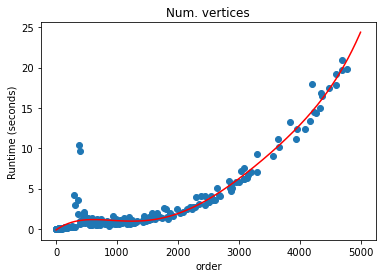

Model selected using Akaike criterion under assumption of polynomial time complexity:
AIC = 725.964660791653
BIC = 733.0860240536841


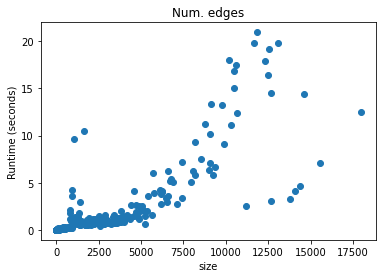

In [10]:
# Let's plot some things.

# num vertices
fig, ax1 = plt.subplots()
xvals = np.linspace(0, 5000, 5000)
ax1.scatter(orders, runtimes)
ax1.plot(xvals, orderCoeff(xvals), color="red")
ax1.set_title("Num. vertices")
ax1.set_xlabel("order")
ax1.set_ylabel("Runtime (seconds)")
plt.show()
predOrderYT = orderCoeff(len(G_full.nodes()))
#print("Estimated runtime for full YT embeddings on local machine is " +
#str(predOrderYT/3600) + " hours.")
print("Model selected using Akaike criterion under assumption of polynomial time complexity:")
print("AIC = " + str(aic))
print("BIC = " + str(bic))

# num edges
fig, ax2 = plt.subplots()
ax2.scatter(sizes, runtimes)
ax2.set_title("Num. edges")
ax2.set_xlabel("size")
ax2.set_ylabel("Runtime (seconds)")
plt.show()


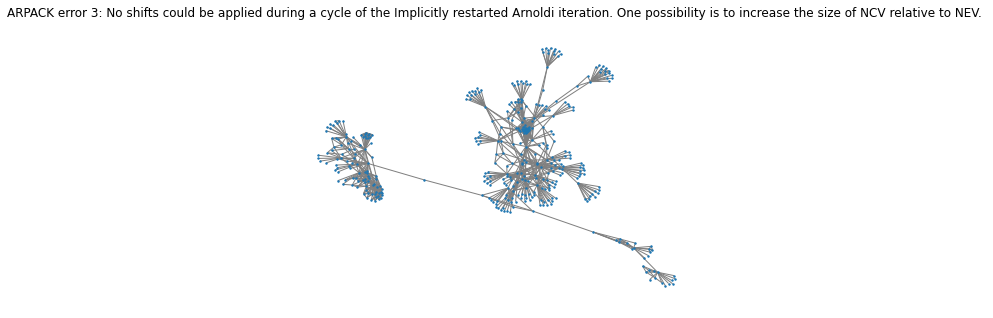

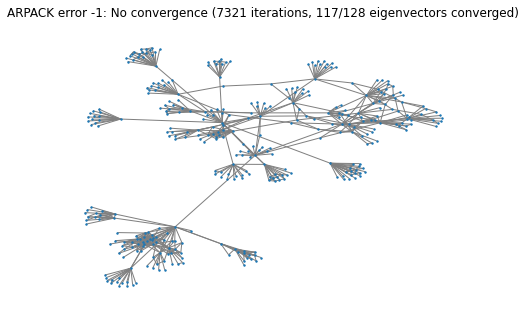

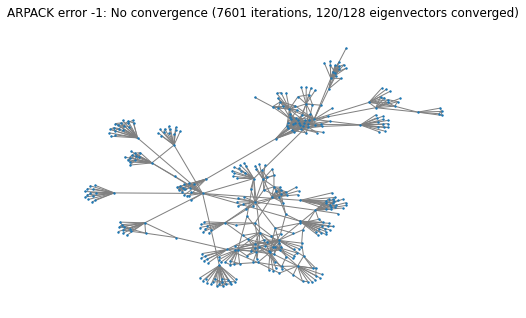

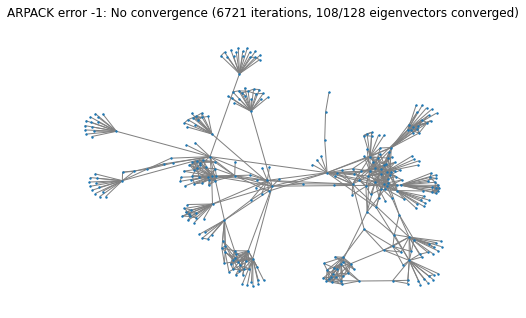

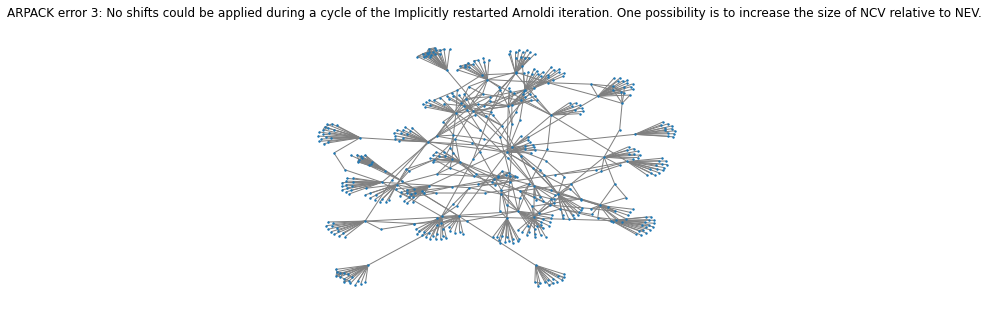

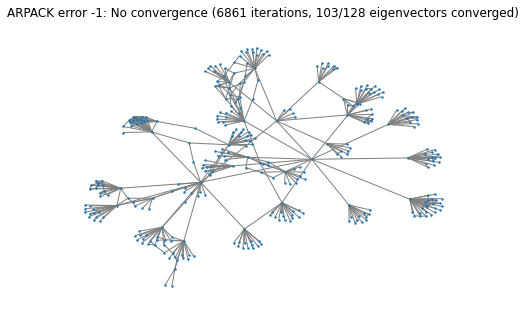

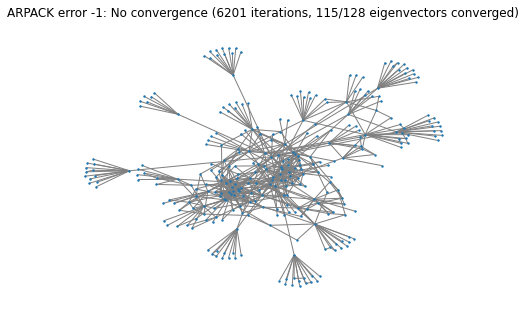

In [449]:
# Examine embedding failures.
# These are graphs that Arlei's code was not able to produce embeddings for.

plot_num = 0
for G_bad in test_bads.keys():
    plt.figure(plot_num)
    nx.draw_spring(G_bad, node_size=2, edge_color="grey", width=1)
    plt.title(test_bads[G_bad])
    plot_num = plot_num + 1
    
# REMARK: I did some basic logistic regressions to try to detect when failures would occur.
# It doesn't work because bad cases are rare and don't seem to have any obvious differences from the normal, good cases.